In [23]:
import healpy as hp
import numpy as np
import DS_Coma_Cluster_param as cc_prm
import DS_healpix_fragmentation as hp_frag
import DS_data_transformation as data_tr
from matplotlib import pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
depth = int(np.log2(2048 // cc_prm.big_nside))
depth

8

In [3]:
matr = hp_frag.one_pixel_fragmentation(cc_prm.big_nside, cc_prm.big_ipix, depth)

In [4]:
mdict = hp_frag.matr2dict(matr)

In [18]:
circle_pic = hp_frag.draw_proper_circle(cc_prm.ra_center, cc_prm.dec_center, 
                                        cc_prm.radius, 
                                        2048, mdict, matr.shape, coords_mode=False)
circle_pic.shape

(256, 256)

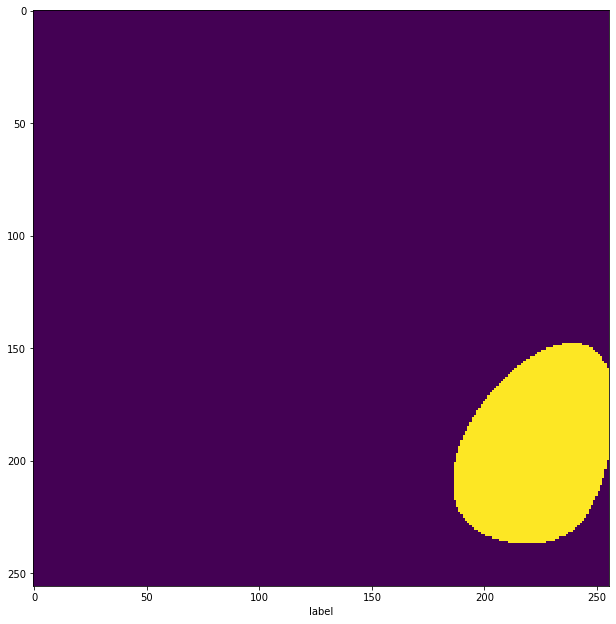

In [19]:
data_tr.show_pic(circle_pic)

In [13]:
circle_coords = hp_frag.draw_proper_circle(cc_prm.ra_center, cc_prm.dec_center, 
                                        1.68 / 2, 
                                        2048, mdict, (2048, 2048), coords_mode=True)

In [15]:
print(circle_coords[:,0].min() - circle_coords[:,0].max() + 64)
print(circle_coords[:,1].min() - circle_coords[:,1].max() + 64)

-4
10


In [16]:
x = -2
y = 5

In [17]:
small_matr = matr[circle_coords[:,0].min() - x: circle_coords[:,0].max() + x,
                 circle_coords[:,1].min() - y: circle_coords[:,1].max() + y]
small_matr.shape

(64, 64)

In [2]:
def gen_matr(ra, dec, radius=0.84, size=64, fin_nside=2048):
    from DS_healpix_fragmentation import find_biggest_pixel, one_pixel_fragmentation,\
        draw_proper_circle, matr2dict
    import numpy as np
    
    big_nside, big_ipix = find_biggest_pixel(ra, dec, radius)
    depth = int(np.log2(fin_nside // big_nside))
    big_matr = one_pixel_fragmentation(big_nside, big_ipix, depth)
    big_dict = matr2dict(big_matr)
    
    
    circle_coords = draw_proper_circle(ra, dec, radius, fin_nside, big_dict, 
                                       big_matr.shape, coords_mode=True)
    mins = [None, None]
    maxs = [None, None]
    for i in range(2):
        dif = circle_coords[:,i].min() - circle_coords[:,i].max() + size
        mins[i] = circle_coords[:,i].min() - dif
        maxs[i] = circle_coords[:,i].max() + dif
        if maxs[i] - mins[i] != size:
            maxs[i] -= maxs[i] - mins[i] - size
    
   
    return big_matr[mins[0]:maxs[0],mins[1]:maxs[1]]

In [17]:
matr = gen_matr(cc_prm.ra_center, cc_prm.dec_center)

In [18]:
mdict = hp_frag.matr2dict(matr)

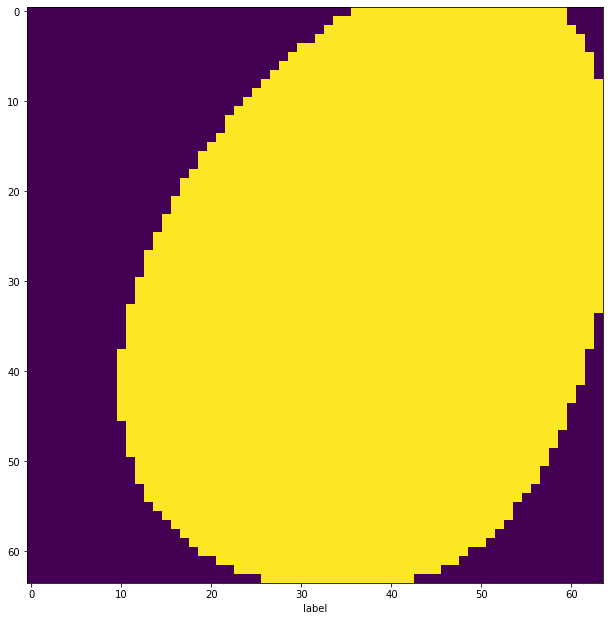

In [19]:
circle_pic = hp_frag.draw_proper_circle(cc_prm.ra_center, cc_prm.dec_center, 
                                        0.84, 
                                        2048, mdict, matr.shape, coords_mode=False)
data_tr.show_pic(circle_pic)

In [3]:
def draw_pic(matr, dirname='/home/rt2122/Data/Planck/normalized/'):
    import os
    import numpy as np
    
    files = sorted(next(os.walk(dirname))[-1])
    pic = np.zeros(list(matr.shape) + [len(files)])
    
    for i_f, file in enumerate(files):
        i_s = np.load(os.path.join(dirname, file))
        
        for x in range(pic.shape[0]):
            pic[x, :, i_f] = i_s[matr[x]]
    return pic

In [21]:
pic = draw_pic(matr)

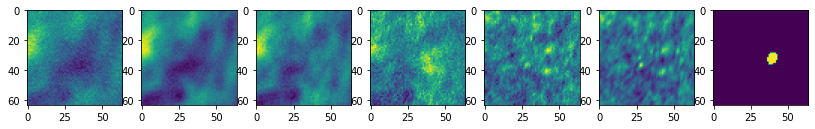

In [28]:
fig, ax = plt.subplots(1, 7, figsize=(14, 2))
for i in range(7):
        ax[i].imshow(pic[:,:,i])

In [5]:
def draw_pic_with_mask(center, clusters, radius=0.84, size=64, fin_nside=2048, 
                       dirname='/home/rt2122/Data/Planck/normalized/', 
                      mask_radius=5/60):
    from DS_healpix_fragmentation import matr2dict, draw_proper_circle
    import numpy as np
    
    matr = gen_matr(center[0], center[1], radius, size, fin_nside)
    mdict = matr2dict(matr)
    
    pic = draw_pic(matr, dirname)
    
    mask = np.zeros(list(matr.shape) + [1], dtype=np.uint8)
    for ra, dec in clusters:
        mask = np.logical_or(mask, 
            draw_proper_circle(ra, dec, mask_radius, fin_nside, mdict, 
                              mask.shape, coords_mode=False))
    
    return pic, mask

In [19]:
pic, mask = draw_pic_with_mask([194.8669, 27.9965], 
                               [[cc_prm.ra_center, cc_prm.dec_center],
                               [194.7474, 28.2341],
                               [191.1374, 28.1766]])

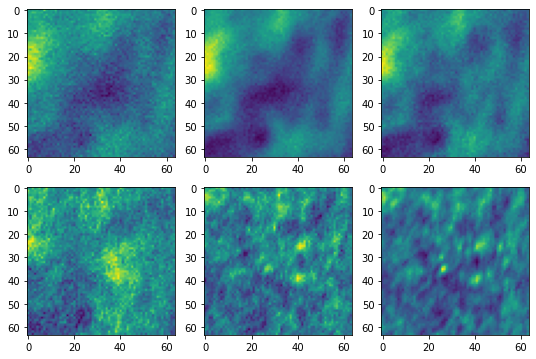

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(9, 6))
for i in range(2):
    for j in range(3):
        ax[i][j].imshow(pic[:,:,j+3*i])

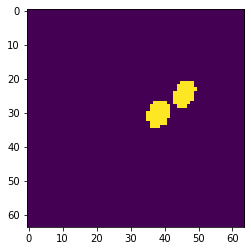

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(mask[:,:,0])

In [21]:
matr = gen_matr(cc_prm.ra_center, cc_prm.dec_center)

In [28]:
pixels = np.array([[0, 0],
          [0, 32],
          [32, 0],
          [32, 63],
          [63, 32], 
          [63, 63],
          [0, 63], 
          [63, 0]])

In [24]:
theta, phi = hp.pix2ang(ipix=matr[32, 32], nside=2048, nest=True, lonlat=True)

In [26]:
cen = SkyCoord(l=theta*u.degree, b=phi*u.degree, frame='galactic')

In [29]:
theta, phi = hp.pix2ang(ipix=matr[pixels[:,0], pixels[:,1]], nside=2048, 
                        nest=True, lonlat=True)

In [30]:
corners = SkyCoord(l=theta*u.degree, b=phi*u.degree, frame='galactic')

In [31]:
cen.separation(corners).degree.min()

0.8260710576664613